In [833]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from fitter import Fitter
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import ADFTest
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
sns.set_style('darkgrid')
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# import shap

In [834]:
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data/Pivot')

In [904]:
# smd_pivot = pd.read_csv('smd_pivot.csv')
# ts_pivot = pd.read_csv('ts_pivot.csv')
# ct = pd.read_csv('ct_spend.csv') # need information on revenue or impressions
dm_pivot = pd.read_csv('dm_pivot_2.csv')

This summary of different stats for the original model can be compared to the .describe()
of the imputed dataset to see how it changed (or didn't change).

In [905]:
df = dm_pivot
df.describe()

,onlinedisplay_S,onlinedisplay_I,onlinevideo_S,onlinevideo_I,paidsearch_S,paidsearch_I,social_S,social_I,revenue
count,35.000000,3.500000e+01,28.000000,2.800000e+01,30.000000,30.000000,34.000000,3.400000e+01,3.700000e+01
mean,11240.428571,1.971870e+06,7463.750000,9.599610e+05,5116.200000,81793.966667,27690.029412,5.357001e+06,9.142247e+06
std,7214.307803,1.628003e+06,5128.264833,5.943764e+05,2769.419625,41544.174094,27663.770344,5.799421e+06,9.188427e+06
min,0.000000,1.000000e+00,254.000000,1.564300e+04,939.000000,18516.000000,984.000000,7.908000e+04,0.000000e+00
25%,5666.500000,4.493080e+05,4869.000000,6.236930e+05,2533.250000,44492.500000,5055.250000,5.447605e+05,1.869905e+06
50%,10050.000000,1.652267e+06,5441.500000,7.912030e+05,5182.000000,88437.000000,16677.500000,3.845664e+06,5.583315e+06
75%,15740.000000,3.125565e+06,8136.500000,1.144556e+06,7976.000000,121167.000000,47387.250000,8.738664e+06,1.437236e+07
max,35292.000000,6.089821e+06,22452.000000,2.768834e+06,9554.000000,141109.000000,92634.000000,1.864317e+07,3.135241e+07


In [906]:
def missing_values(df):
    names = [var for var in df.columns]
    missing_count = df[names].isnull().sum()
    var_count = np.array(df[names].isnull().sum() * 100/ len(df)).round(2)
    missing = pd.DataFrame(index=names)
    missing["Count Missing"] = missing_count
    missing["Percent Missing"] = var_count
    print(missing)


def dickey_fuller(df):
    adf_test = ADFTest(alpha = .05)
    print('A value of True means that the ADFTest null hypothesis that the time series is non-stationary is correct.')
    result = adf_test.should_diff(df['revenue'])
    return result


def unique(df):
    percent_unique = np.array(100 * df.nunique()/len(df.index)).round(2)
    count_unique = df.nunique()
    names = [var for var in df.columns]
    unique_df = pd.DataFrame(index=names)
    unique_df["Count Unique"] = count_unique
    unique_df["Percent Unique"] = percent_unique
    print(unique_df)


def corr_plot(df):
    corr_temp = df.drop(['DATE'], axis=1)
    corr_names = corr_temp.columns.tolist()
    temp_df = df[corr_names]
    corr = temp_df.corr(method="pearson").round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(18, 18))
    cmap = sns.diverging_palette(250, 1, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


def summary(df):
    print(missing_values(df))
    print(unique(df))
    corr_plot(df)

This summary gives us information on missing values, the number of unique values, and correlation before imputation.
In some cases, it suggests that columns of entirely missing data might be dropped right away. Once again, it is valuable
to compare to the imputed result.

                 Count Missing  Percent Missing
DATE                         0             0.00
onlinedisplay_S              8            18.60
onlinedisplay_I              8            18.60
onlinevideo_S               15            34.88
onlinevideo_I               15            34.88
paidsearch_S                13            30.23
paidsearch_I                13            30.23
social_S                     9            20.93
social_I                     9            20.93
revenue                      6            13.95
None
                 Count Unique  Percent Unique
DATE                       43          100.00
onlinedisplay_S            35           81.40
onlinedisplay_I            35           81.40
onlinevideo_S              28           65.12
onlinevideo_I              28           65.12
paidsearch_S               30           69.77
paidsearch_I               30           69.77
social_S                   34           79.07
social_I                   34           79.07
revenue

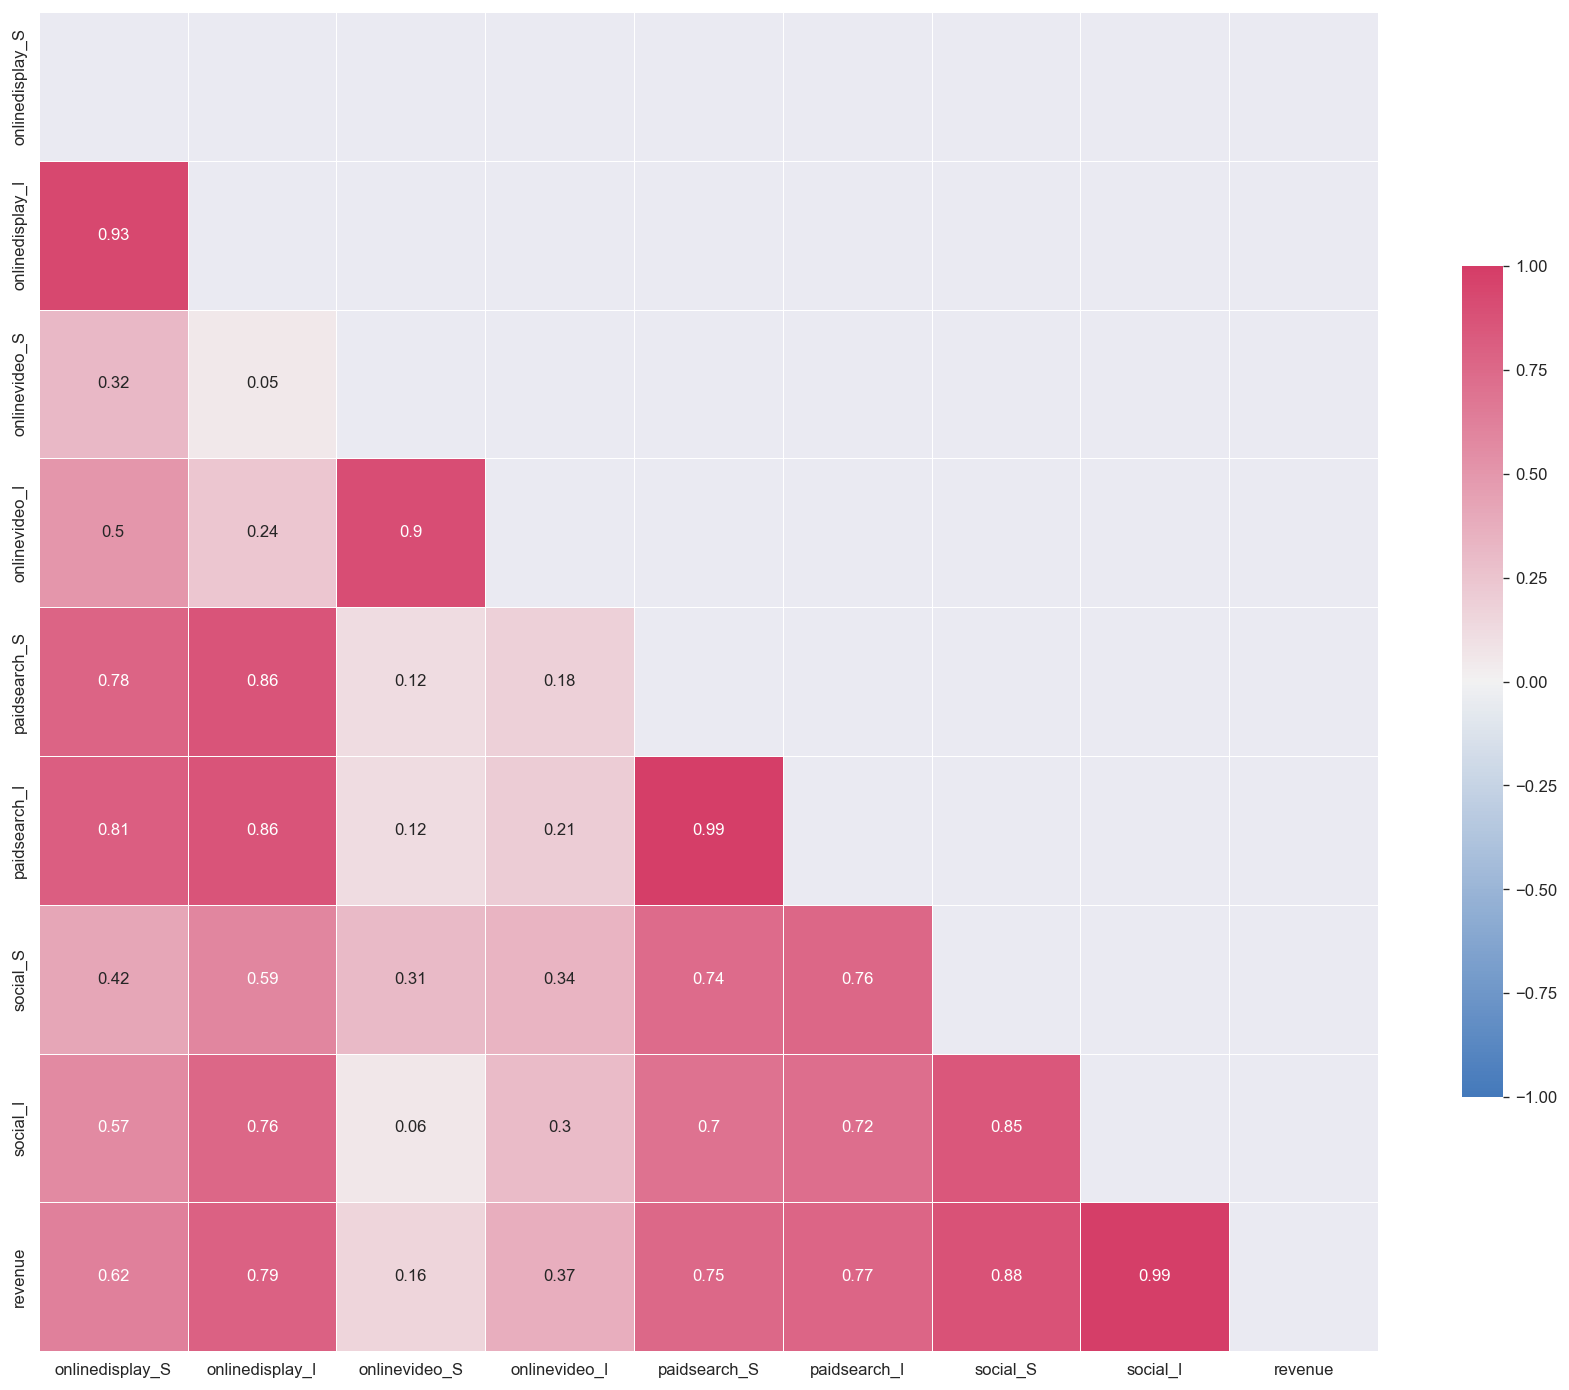

In [907]:
summary(df)

Helps drop variables when necessary and creates a few variables that will be used later.

In [908]:
# df = df.drop([], axis=1)
temp_week = df['DATE']
corr_temp = df.drop(['DATE'], axis=1)
corr_names = corr_temp.columns.tolist()

The KNNImputer uses a method similar to regression and nearby non-missing values to fill in missing values.
The number of neighboring values can be adjusted to find better fits for the missing values.

In [909]:
# # KNN Imputation
# df_knn = temp_df.filter([], axis=1).copy()
# # Define scaler to set values between 0 and 1
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
# # Define KNN imputer and fill missing values
# knn_imputer = KNNImputer(n_neighbors=12, weights='distance', metric='nan_euclidean')
# df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [910]:
df = df.drop(columns='DATE')
imputer = KNNImputer(n_neighbors=10, weights='distance', metric='nan_euclidean')
imputed_KNN = imputer.fit_transform(df)
imputed_KNN = pd.DataFrame(imputed_KNN, columns = df.columns)
KNN_imputation = pd.concat([imputed_KNN, temp_week], axis=1)

Multiple Imputation by Chained Equations (MICE) uses iterations of Bayesian Ridge Linear models
and takes the averages of their results to determine the imputed values. Compared to most other methods,
it performs better with extremely sparse data.

In [911]:
mice_names = tuple(corr_names)
mice_temp = df[corr_names]
df_mice = mice_temp.filter(mice_names, axis=1).copy()

mice_estimator = IterativeImputer(estimator=linear_model.BayesianRidge(), sample_posterior=True, max_iter=40,
                                n_nearest_features=10, imputation_order='random', min_value=500)
df_mice_imputed = pd.DataFrame(mice_estimator.fit_transform(df_mice), columns=df_mice.columns)
imputed_mice = pd.concat([df_mice_imputed, temp_week], axis=1)

In [912]:
# imputed_mice.to_csv('smd_mice_1.csv', encoding='utf-8', index=False)
# KNN_imputation.to_csv('smd_KNN_1.csv', encoding='utf-8', index=False)

### Post Hoc Tests

The Augmented Dickey-Fuller function tests if a time series needs differencing,
which returns True, or if the time series is stationary. It also implies that
if the test returns True, it is not a random walk and the imputation is somewhat
decent, at the minimum.

In [915]:
df = imputed_mice

In [916]:
dickey_fuller(df)

A value of True means that the ADFTest null hypothesis that the time series is non-stationary is correct.


(0.0584036877740908, True)

Autocorrelation is another test for time series that tests if the current date's value is correlated
with previous observations. If the blue line is above the dotted line, this suggests the time series
is autocorrelated as well as the time series not being random.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

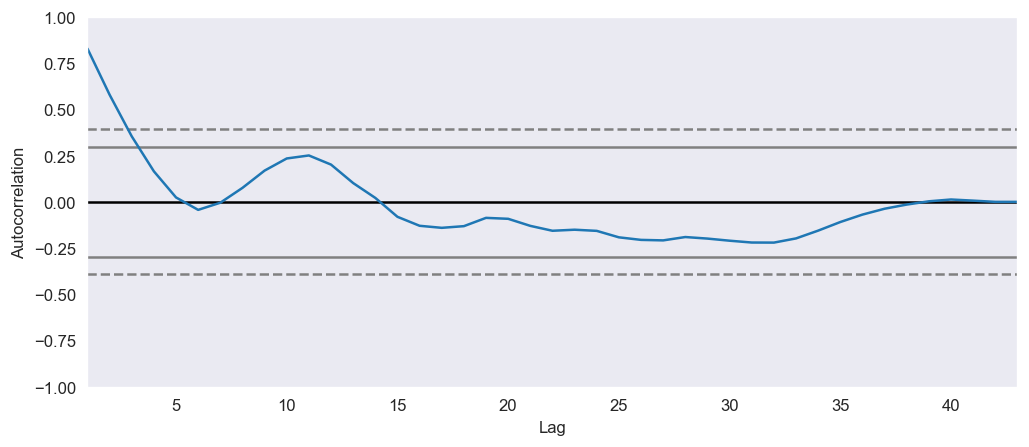

In [917]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['revenue'].tolist())

The following tests plot the distribution of the variables in the imputed dataset,
as well as give you the most likely distribution of its parameters. This can be useful
for testing if the distribution is known or comparing against a similar variable whose
distribution as known. It could also be used in creating synthetic data.

In [918]:
temp_df = df.drop(['DATE'], axis=1)
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_df:
    dist_test = temp_df[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 95.92it/s]


onlinedisplay_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
norm        1.930840e-07  2238.671537 -818.995249     inf      0.111136   
gamma       1.945309e-07  2198.018683 -814.913015     inf      0.096501   
cauchy      2.116351e-07  2227.848132 -815.050493     inf      0.120870   
expon       2.235077e-07  2177.099465 -812.703467     inf      0.224740   
uniform     2.280093e-07  2098.282318 -811.846019     inf      0.359346   

         ks_pvalue  
norm      0.622922  
gamma     0.782496  
cauchy    0.517308  
expon     0.021723  
uniform   0.000018  
{'norm': {'loc': 11941.037338817718, 'scale': 6962.586865455323}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 73.36it/s]


onlinedisplay_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       7.205088e-12  3218.617238 -1253.666054     inf      0.104879   
expon       7.222613e-12  3218.917745 -1257.322793     inf      0.102497   
norm        8.152683e-12  3232.582835 -1252.114190     inf      0.132787   
cauchy      8.240157e-12  3294.355019 -1251.655280     inf      0.197462   
uniform     8.532657e-12  3128.425817 -1250.155380     inf      0.304210   

         ks_pvalue  
gamma     0.692342  
expon     0.718521  
norm      0.399426  
cauchy    0.060508  
uniform   0.000499  
{'gamma': {'a': 1.137790183944954, 'loc': -7604.41678083743, 'scale': 1637717.9030652835}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.34it/s]


onlinevideo_S
         sumsquare_error            aic         bic  kl_div  ks_statistic  \
cauchy      5.012002e-07    2216.520193 -777.978397     inf      0.127757   
norm        5.762417e-07    2168.365426 -771.978967     inf      0.172515   
expon       6.392553e-07    2102.671328 -767.516566     inf      0.260473   
uniform     7.080476e-07    2005.551495 -763.121651     inf      0.436782   
gamma       9.109897e-07  629786.514924 -748.523575     inf      0.976744   

            ks_pvalue  
cauchy   4.472300e-01  
norm     1.372238e-01  
expon    4.614856e-03  
uniform  5.564828e-08  
gamma    1.153152e-70  
{'cauchy': {'loc': 5534.025532225425, 'scale': 1733.4609725303965}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 91.44it/s]


onlinevideo_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
cauchy      2.962885e-11  3146.638141 -1196.626927     inf      0.109613   
gamma       3.058737e-11  3076.145317 -1191.496668     inf      0.125106   
norm        3.137937e-11  3116.241098 -1194.158627     inf      0.127745   
expon       3.693327e-11  3054.731697 -1187.151262     inf      0.272436   
uniform     3.889257e-11  2969.654232 -1184.928579     inf      0.396711   

         ks_pvalue  
cauchy    0.639823  
gamma     0.473614  
norm      0.447348  
expon     0.002605  
uniform   0.000001  
{'cauchy': {'loc': 759182.4268274159, 'scale': 260925.21429292945}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


paidsearch_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
expon           0.000002  1940.192602 -713.917824     inf      0.159389   
gamma           0.000002  1934.936492 -709.873787     inf      0.154493   
uniform         0.000002  1869.689317 -711.943666     inf      0.260481   
norm            0.000002  1928.075347 -710.809932     inf      0.203099   
cauchy          0.000003  1987.433816 -708.791693     inf      0.193060   

         ks_pvalue  
expon     0.201810  
gamma     0.231162  
uniform   0.004613  
norm      0.049510  
cauchy    0.070487  
{'expon': {'loc': 794.1049640529028, 'scale': 4219.957403181349}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


paidsearch_I
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
uniform     1.267450e-08  2379.338384 -936.107175     inf      0.193415   
gamma       1.267926e-08  2428.611677 -932.329832     inf      0.149947   
expon       1.287298e-08  2443.820083 -935.439028     inf      0.151228   
norm        1.332855e-08  2422.650400 -933.943569     inf      0.178037   
cauchy      1.388157e-08  2487.310081 -932.195465     inf      0.178677   

         ks_pvalue  
uniform   0.069633  
gamma     0.261179  
expon     0.252446  
norm      0.115590  
cauchy    0.113275  
{'uniform': {'loc': 18516.0, 'scale': 143873.81628446103}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 50.37it/s]


social_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma       4.542463e-08  2552.015518 -877.458093     inf      0.238601   
expon       5.410215e-08  2410.532756 -873.702053     inf      0.243503   
cauchy      5.960894e-08  2583.117515 -869.533994     inf      0.288346   
norm        6.922694e-08  2403.575183 -863.101863     inf      0.211055   
uniform     7.040846e-08  2290.199864 -862.374161     inf      0.421638   

            ks_pvalue  
gamma    1.225126e-02  
expon    9.920267e-03  
cauchy   1.166811e-03  
norm     3.693872e-02  
uniform  1.904839e-07  
{'gamma': {'a': 0.8277721972354533, 'loc': 499.99999999999994, 'scale': 16701.947438428062}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


social_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       1.027439e-12  3561.795032 -1337.417917     inf      0.173591   
expon       1.439153e-12  3480.957001 -1326.688761     inf      0.288734   
cauchy      1.582631e-12  3667.872046 -1322.602298     inf      0.319232   
norm        1.867228e-12  3466.943453 -1315.491543     inf      0.211425   
uniform     1.906419e-12  3352.192730 -1314.598368     inf      0.424254   

            ks_pvalue  
gamma    1.327698e-01  
expon    1.143435e-03  
cauchy   2.134374e-04  
norm     3.642811e-02  
uniform  1.545860e-07  
{'gamma': {'a': 0.6870367911193962, 'loc': 499.9999999999999, 'scale': 4572633.446551917}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 45.54it/s]

revenue
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon       2.823654e-13  3561.524637 -1396.718903     inf      0.148829   
gamma       2.832203e-13  3597.174057 -1392.827710     inf      0.148182   
cauchy      3.276196e-13  3692.174325 -1390.326901     inf      0.247984   
norm        3.638193e-13  3560.366932 -1385.820327     inf      0.187253   
uniform     3.769425e-13  3456.160352 -1384.296602     inf      0.367854   

         ks_pvalue  
expon     0.268977  
gamma     0.273568  
cauchy    0.008147  
norm      0.085750  
uniform   0.000010  
{'expon': {'loc': 0.0, 'scale': 8625880.741673827}}


<AxesSubplot: xlabel='revenue', ylabel='Density'>

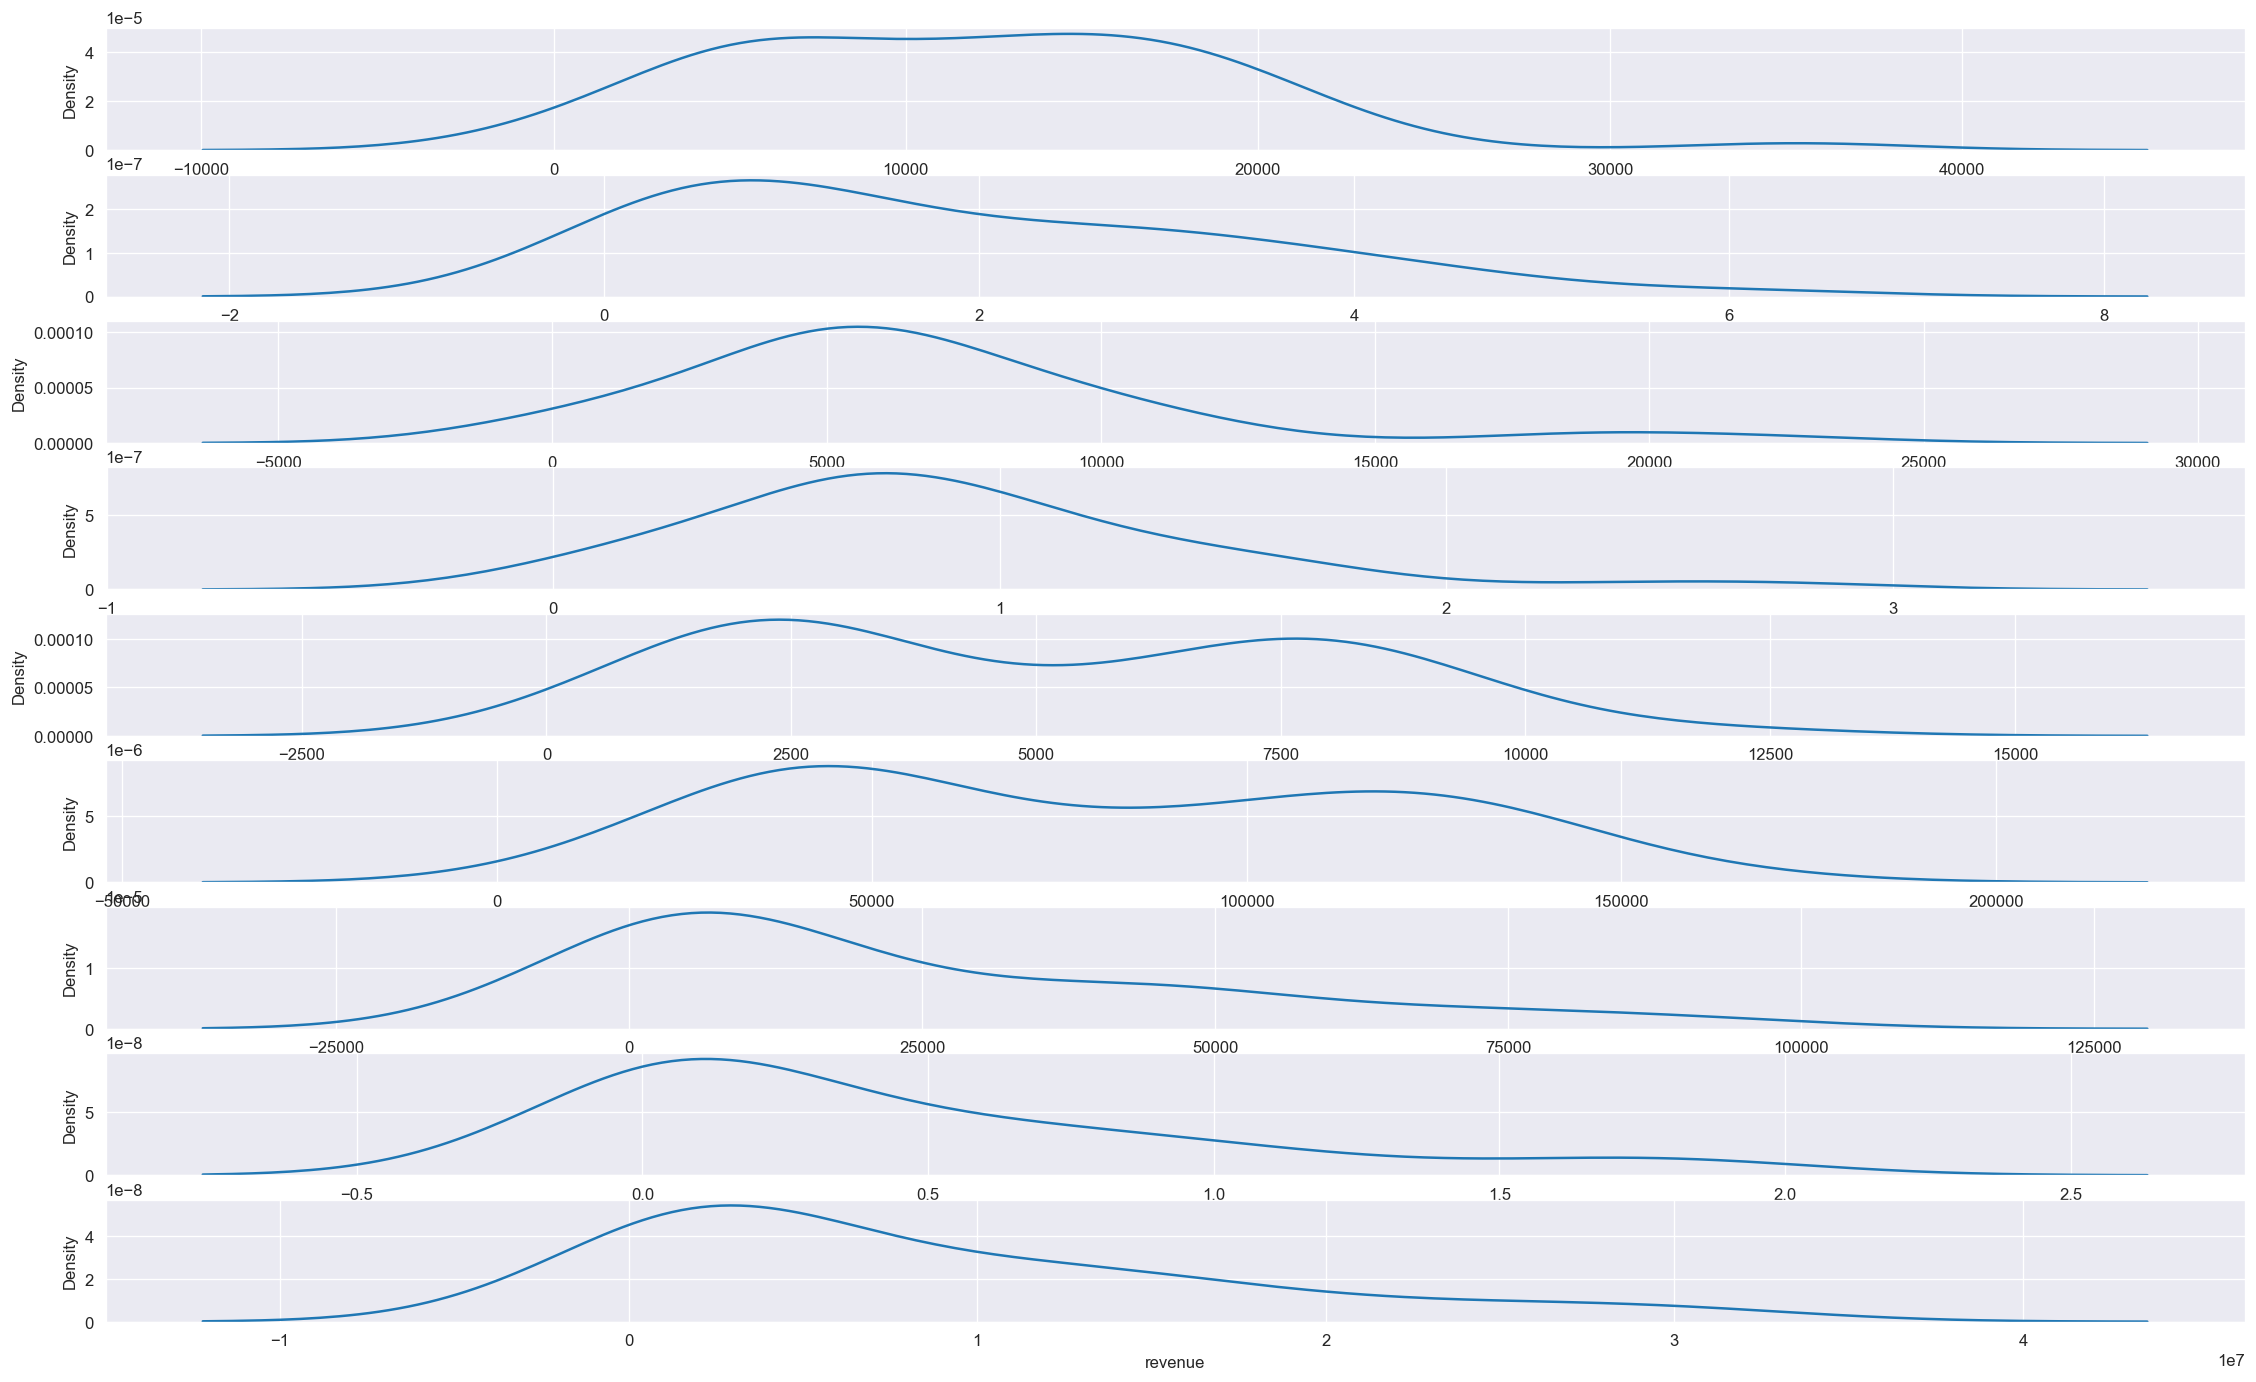

In [919]:
figure, axes = plt.subplots(9, 1, figsize=(23, 14))
sns.kdeplot(ax=axes[0], x='onlinedisplay_S', data=df)
sns.kdeplot(ax=axes[1], x='onlinedisplay_I', data=df)
sns.kdeplot(ax=axes[2], x='onlinevideo_S', data=df)
sns.kdeplot(ax=axes[3], x='onlinevideo_I', data=df)
sns.kdeplot(ax=axes[4], x='paidsearch_S', data=df)
sns.kdeplot(ax=axes[5], x='paidsearch_I', data=df)
sns.kdeplot(ax=axes[6], x='social_S', data=df)
sns.kdeplot(ax=axes[7], x='social_I', data=df)
sns.kdeplot(ax=axes[8], x='revenue', data=df)